# Combination of Spatial Transformer and VGG16
Download the VGG16 weights to the folder "checkpoints" from this source:

https://github.com/tensorflow/models/tree/master/research/slim

The data should be stored as follows

.../train<pre>
/pso
/ecz
</pre>
.../validation <pre>
/pso  
/ecz 
</pre>
.../test<pre>
/pso  
/ecz  
</pre>


In [1]:
# for specifying which GPU to use
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="4"

import tensorflow as tf

/home/nbip/.conda/envs/tf/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
import glob
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
from skimage.transform import resize
from random import shuffle
import pickle
import datetime
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

Using TensorFlow backend.


## Visualize the input

In [9]:
DIM = 224
nchannels = 3
img_height, img_width = DIM, DIM
NUM_CLASSES = 2
NUM_EPOCHS = 50
BATCH_SIZE = 100 # batch size of 128 is too big when training the full model (the FC or STN alone is okay)
# channel means subtracted in the prerocessing step can be found here 
# https://github.com/tensorflow/models/blob/master/research/slim/preprocessing/vgg_preprocessing.py

In [5]:
checkpoints_dir =          # path to the VGG16 weights
train_data_dir =           # path to the train data directory
validation_data_dir =      # path to the validation data directory
test_data_dir =            # path to the test data directory
tensorboard_dir =          # path to the tensorboard directory

train_pso = glob.glob(train_data_dir + "/pso/*.png")
train_ecz = glob.glob(train_data_dir + "/ecz/*.png")
val_pso = glob.glob(validation_data_dir + "/pso/*.png")
val_ecz = glob.glob(validation_data_dir + "/ecz/*.png")

In [11]:
datagen = ImageDataGenerator(
    rescale=1. / 255,
    preprocessing_function = preprocess_input
)

train_generator = datagen.flow_from_directory(
        train_data_dir,  
        target_size=(img_height, img_width),  
        batch_size=BATCH_SIZE,
        class_mode='categorical')  

validation_generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 40000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


## Visualize the input

In [ ]:
n = 4
dummy_batch_size = n*n

x_batch, y_batch = train_generator.next()

idx = 0
canvas = np.zeros((DIM*n, n*DIM, nchannels))
for i in range(n):
    for j in range(n):
        img = x_batch[idx]
        mi = np.min(img)
        img = img - mi
        ma = np.max(img)
        img = img / ma
        canvas[i*DIM:(i+1)*DIM, j*DIM:(j+1)*DIM] = img
        idx += 1
plt.figure(figsize=(10, 10))
plt.imshow(canvas, cmap='gray')
plt.title('canvas of {0}x{0} images'.format(DIM))
plt.axis('off')

plt.show()


# Dependencies and supporting functions

In [18]:
import os
import matplotlib
np.random.seed(123)
import tensorflow as tf

import os
import sys
sys.path.append(os.path.join('.', '..')) 
from spatial_transformer import transformer

from tensorflow.contrib.layers import fully_connected, convolution2d, flatten, max_pool2d, dropout
pool = max_pool2d
conv = convolution2d
dense = fully_connected
from tensorflow.python.ops.nn import relu, softmax
from tensorflow.python.framework.ops import reset_default_graph
from tensorflow.contrib import slim
from tensorflow.contrib.slim.nets import vgg
slim = tf.contrib.slim

## Build the Spatial Transformer

In [19]:
def build_STN_model(x_pl, input_width, input_height, output_dim):
    
    # set up weights for transformation (notice we always need 6 output neurons)
    with tf.name_scope("localization"):
        
        # convert from RGB to HSV
        hsv_image = tf.image.rgb_to_hsv(x_pl)
    
        # make distributed representation of input image for localization network
        loc_l1 = pool(hsv_image, kernel_size=[2, 2], scope="localization_l1")
        loc_l2 = conv(loc_l1, num_outputs=8, kernel_size=[5, 5], stride=[1, 1], padding="SAME", scope="localization_l2")
        loc_l3 = pool(loc_l2, kernel_size=[2, 2], scope="localization_l3")
        loc_l4 = conv(loc_l3, num_outputs=16, kernel_size=[5, 5], stride=[1, 1], padding="SAME", scope="localization_l4")
        loc_l4_flatten = flatten(loc_l4, scope="localization_l4-flatten")
        loc_l5 = dense(loc_l4_flatten, num_outputs=50, activation_fn=relu, scope="localization_l5")


        W_loc_out = tf.get_variable("localization_loc-out", [50, 6], initializer=tf.constant_initializer(0.0))
        initial = np.array([[1, 0, 0], [0, 1, 0]])
        initial = initial.astype('float32')
        initial = initial.flatten()
        b_loc_out = tf.Variable(initial_value=initial, name='b-loc-out')
        loc_out = tf.matmul(loc_l5, W_loc_out) + b_loc_out

    # spatial transformer
    l_trans1 = transformer(x_pl, loc_out, out_size=(DIM, DIM))
    l_trans1.set_shape([None, DIM, DIM, nchannels])

    print( "Transformer network output shape: ", l_trans1.get_shape())

    return l_trans1, loc_out, hsv_image

## Build the VGG16 model

In [21]:
def build_VGG_model(inputs, is_training=True):
    inputs = tf.cast(inputs, tf.float32)
    #Use Pretrained Base Model
    with tf.variable_scope("vgg_16"):
        with slim.arg_scope(vgg.vgg_arg_scope()):
            net = slim.repeat(inputs, 2, slim.conv2d, 64, [3, 3], scope='conv1')
            net = slim.max_pool2d(net, [2, 2], scope='pool1')
            net = slim.repeat(net, 2, slim.conv2d, 128, [3, 3], scope='conv2')
            net2 = slim.max_pool2d(net, [2, 2], scope='pool2')
            net = slim.repeat(net2, 3, slim.conv2d, 256, [3, 3], scope='conv3')
            net = slim.max_pool2d(net, [2, 2], scope='pool3')
            net = slim.repeat(net, 3, slim.conv2d, 512, [3, 3], scope='conv4')
            net = slim.max_pool2d(net, [2, 2], scope='pool4')
            net = slim.repeat(net, 3, slim.conv2d, 512, [3, 3], scope='conv5')
            net = slim.max_pool2d(net, [2, 2], scope='pool5')
    #Append fully connected layer
    fc = slim.flatten(net)
    fc = slim.fully_connected(fc, 256,
            weights_initializer=tf.contrib.layers.xavier_initializer(),
            weights_regularizer=slim.l2_regularizer(0.5),
            scope='finetune/fc1')
    fc = slim.dropout(fc, 0.5)
    fc_out= slim.fully_connected(fc, 2,
            activation_fn=tf.nn.softmax,
            weights_initializer=tf.contrib.layers.xavier_initializer(),
            weights_regularizer=slim.l2_regularizer(0.5),
            scope='finetune/fc2')
    print( "VGG model output shape: ", net.get_shape())
    return net, fc_out, net2



In [22]:
def loss_and_acc(logits, labels):
    with tf.name_scope("loss"):
        # weight the logits by the class imbalance
        # computing cross entropy per sample
        cross_entropy = -tf.reduce_sum(labels * tf.log(logits+1e-8), reduction_indices=[1])

        # averaging over samples
        cross_entropy = tf.reduce_mean(cross_entropy)
        
        # accuracy
        argmax_logits = tf.to_int32(tf.argmax(logits, axis=1))
        argmax_labels = tf.to_int32(tf.argmax(labels, axis=1))
        correct = tf.to_float(tf.equal(argmax_logits, argmax_labels))
        accuracy = tf.reduce_mean(correct)
        
        # precision
        prec = tf.metrics.precision(argmax_labels, argmax_logits)
        
        # recall
        rec = tf.metrics.recall(argmax_labels, argmax_logits)
        
        # AUC of the ROC
        auc, update_op_auc = tf.metrics.auc(labels, logits)


    return cross_entropy, accuracy, argmax_logits, prec, rec, update_op_auc
        
def optimize(losses, lr_pl, trainable_vars, g_step):
    
    # defining our optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=lr_pl)

    # applying the gradients
    train_op = optimizer.minimize(losses, var_list=trainable_vars, global_step=g_step)
    
    return train_op

## Stitch it together

In [23]:
tf.reset_default_graph()

# input images
x_pl = tf.placeholder(tf.float32, [None, DIM, DIM, nchannels], name="input")
# corresponding labels as onehot encoding
y_pl = tf.placeholder(tf.float32, shape=[None, NUM_CLASSES], name="output")
# learning rate placeholder
lr_pl = tf.placeholder(tf.float32, shape=[], name="learning-rate")
# keep track of training steps. Incremements by 1 each time tf.optimizer.minimize is called
global_step = tf.Variable(initial_value=0, trainable=False)  

# the result of the transform, the weights used for the transform and the HSV image
l_transform, w_transform, hsv = build_STN_model(x_pl, DIM, DIM, NUM_CLASSES)

# The VGG16 model output and the logits from the fully connected layer on top
vgg16_out, logits, vgg16_mid = build_VGG_model(l_transform)

# define losses and training operation
loss, accuracy, prediction, precision, recall, auc_op = loss_and_acc(logits, y_pl)

# training fully connected layers 
trainable_vars1 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"finetune")
train_op1 = optimize(loss, lr_pl, trainable_vars1, global_step)

# training fc + fine tuning VGG16 top layers
trainable_vars2 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"vgg_16/conv5")
trainable_vars2.extend(trainable_vars1)
train_op2 = optimize(loss, lr_pl, trainable_vars2, global_step)

# training fc + STN
trainable_vars3 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"localization")
trainable_vars3.extend(trainable_vars1)
train_op3 = optimize(loss, lr_pl, trainable_vars3, global_step)

# training STN + finetune + fc
trainable_vars4 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"localization")
trainable_vars4.extend(trainable_vars2)
train_op4 = optimize(loss, lr_pl, trainable_vars4, global_step)

# training only STN
trainable_vars5 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"localization")
train_op5 = optimize(loss, lr_pl, trainable_vars5, global_step)

# add TensorBoard summaries for all variables
tf.summary.merge_all()
tf.summary.scalar('Evaluation/loss', loss)
tf.summary.scalar('Evaluation/accuracy', accuracy)

Transformer network output shape:  (?, 224, 224, 3)
VGG model output shape:  (?, 7, 7, 512)


<tf.Tensor 'Evaluation/accuracy:0' shape=() dtype=string>

In [24]:
# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=1)

# initialize the Session
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts))
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())  # this is needed for the precision and recall for some reason

# restorethe VGG_16 weights from file
restore = slim.assign_from_checkpoint_fn(
               os.path.join(checkpoints_dir, 'vgg_16.ckpt'),
               slim.get_model_variables("vgg_16"))
restore(sess)

# Tensorboard
file_writer = tf.summary.FileWriter(tensorboard_dir, sess.graph)
# Make run-options
run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE,
                            output_partition_graphs=True)
run_metadata = tf.RunMetadata()

INFO:tensorflow:Restoring parameters from ./tmp/checkpoints/vgg_16.ckpt


## Test the forward pass

In [25]:
x_batch, y_batch = train_generator.next()
res = sess.run(fetches=logits, feed_dict={x_pl: x_batch})
assert res.shape == (len(x_batch), 2), "ERROR the output shape is not as expected!" \
        + " Output shape should be " + str(y_pl.shape) + ' but was ' + str(res.shape)

print('Forward pass successful!')

Forward pass successful!


## Do the training

In [29]:
# setup and write summaries
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
summaries_path = "tensorboard/%s" % (timestamp)
summaries = tf.summary.merge_all()

summarywriter_train = tf.summary.FileWriter(summaries_path + '/train', sess.graph)
summarywriter_valid = tf.summary.FileWriter(summaries_path + '/valid', sess.graph)

def train_epoch(learning_rate, training_op):
    num_samples = train_generator.n
    num_batches = int(np.ceil(num_samples / float(BATCH_SIZE)))
    costs = []
    accs = []
    precs = []
    recs = []
    for i in range(num_batches):
        if i % 10 == 0:
            print(i, end=', ')
        X_batch_tr, y_batch_tr = train_generator.next()
        fetches_tr = [training_op, loss, accuracy, prediction, precision, recall, summaries, global_step, l_transform, w_transform, auc_op]
        feed_dict_tr = {x_pl: X_batch_tr, y_pl: y_batch_tr, lr_pl: learning_rate}
        res = sess.run(fetches=fetches_tr, feed_dict=feed_dict_tr)
        costs += [res[1]]
        accs += [res[2]]
        recs += [res[4]]
        precs += [res[5]]
        summarywriter_train.add_summary(res[6], res[7])
    print("")    
    auc = res[10] # the auc_op is calculated a running estimate of the auc, therefore we do not have to keep track of this for each batch
    sess.run(tf.local_variables_initializer())  # since the auc is a running estimate we need to reset it after each epoch
    return np.mean(costs), np.mean(accs), np.mean(precs), np.mean(recs), summaries, auc


def eval_epoch():
    num_samples = validation_generator.n
    num_batches = int(np.ceil(num_samples / float(BATCH_SIZE)))
    costs = []
    accs = []
    preds = []
    precs = []
    recs = []
    
    pred_list = []
    y_list = []
    transform_list = []
    weight_list = []
    for i in range(num_batches):
        if i % 10 == 0:
            print(i, end=', ')
        X_batch_val, y_batch_val = validation_generator.next()
        fetches_val = [loss, accuracy, prediction, precision, recall, summaries, global_step, l_transform, w_transform, auc_op]
        feed_dict_val = {x_pl: X_batch_val, y_pl: y_batch_val}
        res = sess.run(fetches=fetches_val, feed_dict=feed_dict_val)
        costs += [res[0]]
        accs += [res[1]]
        preds += [res[2]]
        precs += [res[3]]
        recs += [res[4]]
        summarywriter_valid.add_summary(res[5], res[6])
    preds_ = np.concatenate(preds, axis=0)
    auc = res[9] # the auc_op is calculated a running estimate of the auc, therefore we do not have to keep track of this for each batch
    sess.run(tf.local_variables_initializer())  # since the auc is a running estimate we need to reset it after each epoch
    print('')
    return np.mean(costs), np.mean(accs), preds_, np.mean(precs), np.mean(recs), summaries, auc

In [30]:
NUM_EPOCHS = 50

valid_accs, train_accs, test_accs = [], [], []
valid_precs, train_precs, valid_recs, train_recs = [], [], [], []
train_costs, valid_costs = [], []
train_aucs, valid_aucs = [], []

learning_rate=0.00001
# define which variables are included in the training
tr_op = train_op4
print('Number of epochs: %s' % NUM_EPOCHS)

try:
    for n in range(NUM_EPOCHS):
        print("Epoch %d:" % n, end=', ')
        print('\ntrain:', end=', ')
        train_cost, train_acc, train_prec, train_rec, train_summary, train_auc = train_epoch(learning_rate, tr_op)
        train_costs += [train_cost]
        train_accs += [train_acc]
        train_aucs += [train_auc]
        train_precs += [train_prec]
        train_recs += [train_rec]
        print('valid:', end=', ')
        valid_cost, valid_acc, preds, valid_prec, valid_rec, valid_summary, valid_auc = eval_epoch()
        valid_costs += [valid_cost]
        valid_accs += [valid_acc]
        valid_aucs += [valid_auc]
        valid_precs += [valid_prec]
        valid_recs += [valid_rec]

        print("train cost {0:.2}, train acc {1:.2}, val cost {2:.2}, val acc {3:.2}".format(
                train_cost, train_acc, valid_cost, valid_acc))
        print("train auc {0:.2}, val auc {1:.2}". format(train_auc, valid_auc))
        print("train prec {0:.2}, train rec {1:.2}, val prec {2:.2}, val rec {3:.2}". format(
                train_prec, train_rec, valid_prec, valid_rec))
        
        # learning rate annealing
        if (n+1) % 20 == 0:
            learning_rate = learning_rate * 0.7
            print("New LR:", learning_rate)      
        
except KeyboardInterrupt:
    pass

Number of epochs: 100
Epoch 0:, 
train:, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 
valid:, 0, 10, 20, 30, 
train cost 1.2, train acc 0.51, val cost 0.69, val acc 0.54
train auc 0.51, val auc 0.55
train prec 0.76, train rec 0.5, val prec 0.54, val rec 0.52
Epoch 1:, 
train:, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 
valid:, 0, 10, 20, 30, 
train cost 0.67, train acc 0.58, val cost 0.66, val acc 0.6
train auc 0.62, val auc 0.64
train prec 0.58, train rec 0.57, val prec 0.6, val rec 0.54
Epoch 2:, 
train:, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 
valid

In [31]:
# save session?
saver = tf.train.Saver()
save_path = saver.save(sess, "output/03ST_TL.ckpt")


## Plot errors and zoom

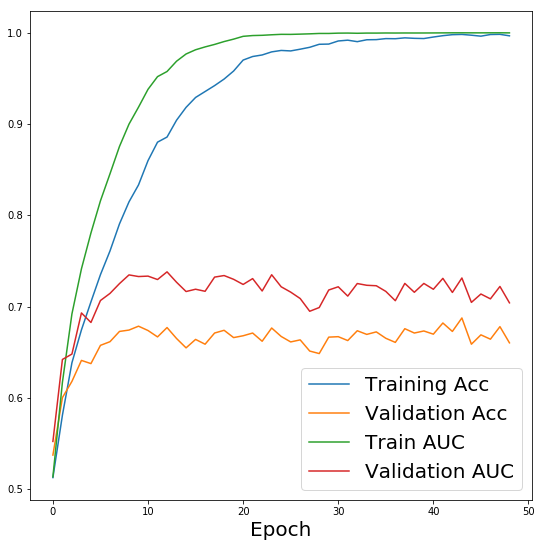

In [54]:
plt.figure(figsize=(9,9))
plt.plot(np.array(train_accs), label='Training Acc')
plt.plot(np.array(valid_accs), label='Validation Acc')
plt.plot(np.array(train_aucs), label='Train AUC')
plt.plot(np.array(valid_aucs), label='Validation AUC')
plt.legend(fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.savefig('output/TL_STN_ACC_AUC')
plt.show()

## Show original image, transformed image and the weights used for transformation

In [ ]:
X_batch_val, y_batch_val = train_generator.next()
fetches_val = [prediction, l_transform, w_transform, hsv, vgg16_mid]
feed_dict_val = {x_pl: X_batch_val}
res = sess.run(fetches=fetches_val, feed_dict=feed_dict_val)
output_eval, transform_eval, weight_eval, hsv_im, convnet = tuple(res)

print(X_batch_val.shape)

plt.figure(figsize=(10,8))

offset = 0

for i in range(3):
    img = X_batch_val[i+offset]
    mi = np.min(img)
    img = img - mi
    ma = np.max(img)
    img = img / ma
    trans = transform_eval[i+offset]
    mi = np.min(trans)
    trans = trans - mi
    ma = np.max(trans)
    trans = trans / ma

    plt.subplot(331+i*3)
    plt.imshow(img, interpolation='none')
    if i == 0:
        plt.title('Original {0}x{0}'.format(X_batch_val.shape[1]), fontsize=10)
    plt.axis('off')
    plt.subplot(332+i*3)
    plt.imshow(trans, interpolation='none')
    if i == 0:
        plt.title('Transformed {0}x{0}'.format(l_transform.shape[1]), fontsize=10)
    plt.axis('off')
    plt.subplot(333+i*3)
    plt.imshow(weight_eval[i+offset].reshape(2,3), interpolation='nearest', cmap='jet')
    plt.colorbar()
    if i == 0:
        plt.title('Transformation weights', fontsize=10)
    plt.axis('off')
    
plt.tight_layout()
# plt.savefig('output/TL_STN_weights')
plt.show()

## Test data

In [46]:
test_generator = datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False)

num_samples = test_generator.n
num_batches = int(np.ceil(num_samples / float(BATCH_SIZE)))

test_logits = np.zeros((num_samples, 2))
y = np.zeros((num_samples, 2))

for i in range(num_batches):

    x_batch_test, y_batch_test = test_generator.next()
    n_batch = x_batch_test.shape[0]
    print("batch no {}, number of samples: {}".format(i+1, n_batch))
    fetches_test = [logits, prediction, accuracy, auc_op]
    feed_dict_test= {x_pl: x_batch_test, y_pl: y_batch_test}
    res = sess.run(fetches=fetches_test, feed_dict=feed_dict_test)
    
    test_logits[i*BATCH_SIZE: i*BATCH_SIZE + n_batch, :] = res[0]
    y[i*BATCH_SIZE: i*BATCH_SIZE + n_batch, :] = y_batch_test

Found 617 images belonging to 2 classes.
batch no 1, number of samples: 100
batch no 2, number of samples: 100
batch no 3, number of samples: 100
batch no 4, number of samples: 100
batch no 5, number of samples: 100
batch no 6, number of samples: 100
batch no 7, number of samples: 17


In [50]:
# For the ROC curve
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y[:, 0], test_logits[:, 0])
auc = metrics.auc(fpr, tpr)
print("Sklearn auc: {}".format(auc))

Sklearn auc: 0.7305633147113593


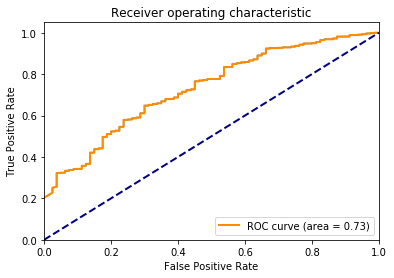

In [51]:
plt.plot(fpr,tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = {0:0.2f})'.format(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('output/TL_STN_ROC')
plt.show()

In [39]:
acc = np.sum(np.equal(np.argmax(y, axis=1), np.argmax(test_logits, axis=1)))/num_samples

print("acc: {0:0.2f}, auc: {1:0.2f}".format(acc, auc))

acc: 0.72, auc: 0.73


In [40]:
# indices for positive and negative examples
idxp = np.argmax(y, axis=1) == 0
idxn = np.argmax(y, axis=1) == 1

tp = np.sum(np.equal(np.argmax(y[idxp, :], axis=1), np.argmax(test_logits[idxp, :], axis=1)))
tn = np.sum(np.equal(np.argmax(y[idxn, :], axis=1), np.argmax(test_logits[idxn, :], axis=1)))
fp = np.sum(np.argmax(y[idxn, :], axis=1) != np.argmax(test_logits[idxn, :], axis=1))
fn = np.sum(np.argmax(y[idxp, :], axis=1) != np.argmax(test_logits[idxp, :], axis=1))

print(tp, tn, fp, fn)

prec = tp / (tp + fp)
rec = tp / (tp + fn)
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)

print("Precision, Recall, TPR, FPR")
print(prec, rec, tpr, fpr)

397 45 35 140
Precision, Recall, TPR, FPR
0.918981481481 0.739292364991 0.739292364991 0.4375


## Inspect classifications on the test set

In [ ]:
n = 17
offset = 0
plt.figure(figsize=(100,100))
for i in range(n):
    plt.subplot(n,1,i+1)
    img = x_batch_test[i + offset]
    mi = np.min(img)
    img = img - mi
    ma = np.max(img)
    img = img / ma
    plt.imshow(img)
    plt.title('logits: {0:3.2}  {1:3.2}, truth: {2}'.format(res[0][i][0],res[0][i][1], y_batch_test[i+offset]))